# Классификация Oxford Pets

Обучим сеть для классификации исходного датасета [Oxford-IIIT Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/).

# Загрузка датасета

In [1]:
import tensorflow_datasets as tfds

train_data, test_data = tfds.load(
    'oxford_iiit_pet',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=False
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete6JWGJQ/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete6JWGJQ/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


# Работа с датасетом

Датасет поделен на обучающую (50%) и тестовую (50%) выборки. Нормализуем данные и приготовим их к обучению.

In [2]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


img_height = 224
img_width = 224
resize = layers.Resizing(img_height, img_width)


def normalize_img(image, label):
    return tf.cast(resize(image), tf.float32), label


train_data = train_data.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE).cache().shuffle(4000)
test_data = test_data.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)

# Обучение моделей

Определим функции для визуализации и определения метрик.

In [3]:
import seaborn as sn
import pandas as pd


def print_metrics(history, epochs=20):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  top3_acc = history.history['top_3_accuracy']
  val_top3_acc = history.history['val_top_3_accuracy']

  top5_acc = history.history['top_5_accuracy']
  val_top5_acc = history.history['val_top_5_accuracy']

  epochs_range = range(epochs)

  plt.figure(figsize=(15, 8))
  plt.subplot(1, 3, 1)
  plt.plot(epochs_range, acc, label='train acc')
  plt.plot(epochs_range, val_acc, label='val acc')
  plt.legend()
  plt.grid()
  plt.title('Accuracy')

  plt.subplot(1, 3, 2)
  plt.plot(epochs_range, top3_acc, label='train top3 acc')
  plt.plot(epochs_range, val_top3_acc, label='val top3 acc')
  plt.legend()
  plt.grid()
  plt.title('Top 3 accuracy')

  plt.subplot(1, 3, 3)
  plt.plot(epochs_range, top5_acc, label='train top5 acc')
  plt.plot(epochs_range, val_top5_acc, label='val top5 acc')
  plt.legend()
  plt.grid()
  plt.title('Top 5 accuracy')

  plt.show()


def cats_vs_dogs(model, data):
  cats = [0, 5, 6, 7, 9, 11, 20, 23, 26, 27, 32, 33]  # определены вручную
  correct = 0
  total = 0

  for x, y in test_data:
    y_pred = np.argmax(model.predict(x), axis=1)
    correct_cats = sum([y_pred[i] in cats and y[i] in cats for i in range(len(y))])
    correct_dogs = sum([y_pred[i] not in cats and y[i] not in cats for i in range(len(y))])
    correct += correct_cats + correct_dogs
    total += len(y)
  print(correct / total)


def plot_confusion_matrix(model, data):
    y_real = np.array([])
    y_pred = np.array([])

    for x, y in data:
        y_real = np.concatenate((y_real, y), axis=None)
        y_pred = np.concatenate((y_pred, np.argmax(model.predict(x), axis=1)), axis=None)    
    conf_matrix = tf.math.confusion_matrix(y_real, y_pred, num_classes=37)
    
    df_cm = pd.DataFrame(conf_matrix, index = [i for i in range(0, 37)], columns = [i for i in range(0, 37)])
    plt.figure(figsize = (15, 15))
    sn.heatmap(df_cm, annot=True, cmap='Blues')
    plt.show()

Сначала сделаем аугментацию данных для улучшения классификации. Далее определим VGG-16, добавив слои с конца.

In [ ]:
augmentation = keras.models.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation([-0.125, 0.125]),
])

aug_train = train_data.map(lambda x, y: (augmentation(x), y))

vgg16 = keras.applications.VGG16(include_top=False, input_shape=(img_height, img_width, 3))
for x in vgg16.layers:
    x.trainable = False

batch_size = 128

train_data = train_data.map(lambda x, y: (keras.applications.vgg16.preprocess_input(x), y)).batch(batch_size)
aug_train = aug_train.map(lambda x, y: (keras.applications.vgg16.preprocess_input(x), y)).batch(batch_size)
test_data = test_data.map(lambda x, y: (keras.applications.vgg16.preprocess_input(x), y)).batch(batch_size)

model = keras.models.Sequential([
    vgg16,
    layers.Flatten(),  # уменьшаем размерность
    layers.Dense(4096, activation='tanh'),
    layers.Dense(4096, activation='tanh'),
    layers.Dense(37)
])

Определим подсчёт top-3 accuracy и top-5 accuracy. Оптимизатором будет Adam, в качестве функции потерь будем использовать CrossEntropyLoss. Обучим модель.

In [ ]:
top3_acc = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top_3_accuracy')
top5_acc = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_5_accuracy')

model.compile(optimizer=tf.keras.optimizers.Adam(0.00001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy', top3_acc, top5_acc])

tf.config.list_physical_devices('GPU')

history = model.fit(
    aug_train,
    validation_data=test_data,
    epochs=10
)

Epoch 1/10
29/29 [==============================] - 75s 2s/step - loss: 3.2993 - accuracy: 0.1446 - top_3_accuracy: 0.2894 - top_5_accuracy: 0.3872 - val_loss: 2.4506 - val_accuracy: 0.3579 - val_top_3_accuracy: 0.6094 - val_top_5_accuracy: 0.7285
Epoch 2/10
29/29 [==============================] - 58s 2s/step - loss: 2.1067 - accuracy: 0.4696 - top_3_accuracy: 0.7103 - top_5_accuracy: 0.8060 - val_loss: 1.6556 - val_accuracy: 0.5803 - val_top_3_accuracy: 0.8209 - val_top_5_accuracy: 0.9005
Epoch 3/10
29/29 [==============================] - 58s 2s/step - loss: 1.4790 - accuracy: 0.6473 - top_3_accuracy: 0.8454 - top_5_accuracy: 0.9101 - val_loss: 1.2742 - val_accuracy: 0.6748 - val_top_3_accuracy: 0.8929 - val_top_5_accuracy: 0.9447
Epoch 4/10
29/29 [==============================] - 58s 2s/step - loss: 1.1251 - accuracy: 0.7399 - top_3_accuracy: 0.9114 - top_5_accuracy: 0.9514 - val_loss: 1.0638 - val_accuracy: 0.7234 - val_top_3_accuracy: 0.9199 - val_top_5_accuracy: 0.9597
Epoch 5/

Результаты после 10 эпох - loss: 0.4574 - accuracy: 0.9065 - top_3_accuracy: 0.9829 - top_5_accuracy: 0.9932 - val_loss: 0.6631 - val_accuracy: 0.8070 - val_top_3_accuracy: 0.9572 - val_top_5_accuracy: 0.9804

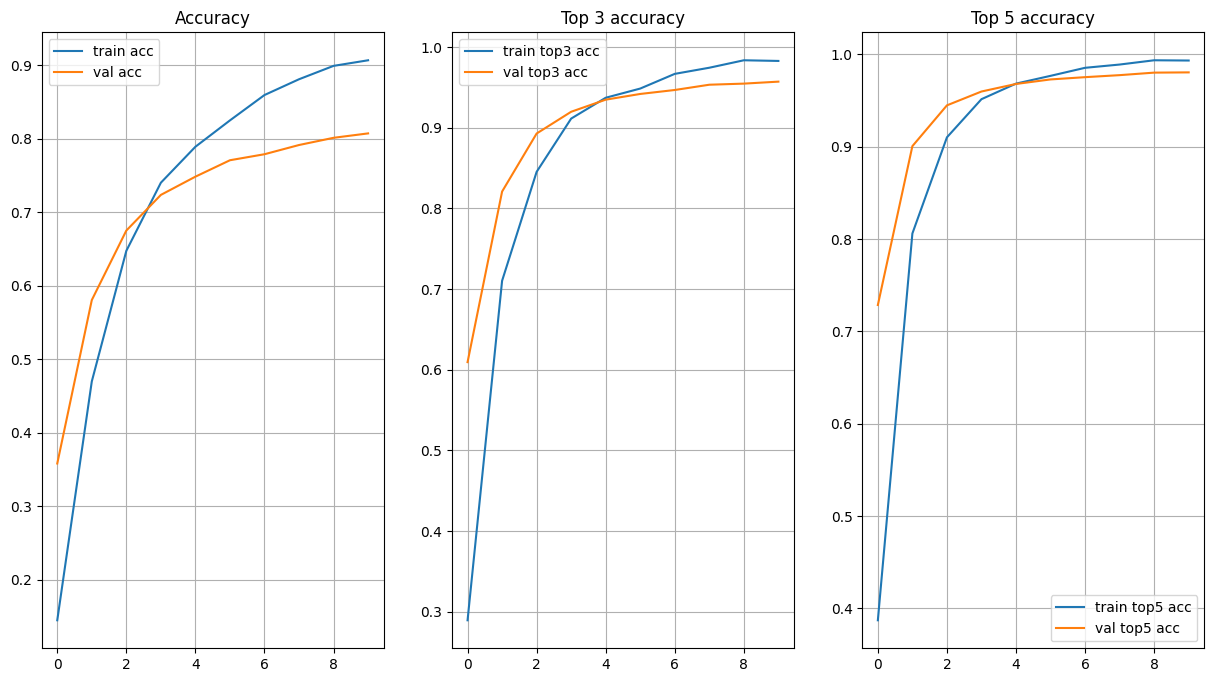

In [ ]:
print_metrics(history, epochs=10)

Обучим теперь VGG-19.

In [ ]:
augmentation = keras.models.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation([-0.125, 0.125]),
])

aug_train = train_data.map(lambda x, y: (augmentation(x), y))

vgg19 = keras.applications.VGG19(include_top=False, input_shape=(img_height, img_width, 3))
for x in vgg19.layers:
    x.trainable = False

batch_size = 128

train_data = train_data.map(lambda x, y: (keras.applications.vgg19.preprocess_input(x), y)).batch(batch_size)
aug_train = aug_train.map(lambda x, y: (keras.applications.vgg19.preprocess_input(x), y)).batch(batch_size)
test_data = test_data.map(lambda x, y: (keras.applications.vgg19.preprocess_input(x), y)).batch(batch_size)

model = keras.models.Sequential([
    vgg19,
    layers.Flatten(),  # уменьшаем размерность
    layers.Dense(4096, activation='tanh'),
    layers.Dense(4096, activation='tanh'),
    layers.Dense(37)
])

top3_acc = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top_3_accuracy')
top5_acc = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_5_accuracy')

model.compile(optimizer=tf.keras.optimizers.Adam(0.00001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy', top3_acc, top5_acc])

tf.config.list_physical_devices('GPU')

history = model.fit(
    aug_train,
    validation_data=test_data,
    epochs=10
)

Epoch 1/10
29/29 [==============================] - 127s 3s/step - loss: 3.2596 - accuracy: 0.1446 - top_3_accuracy: 0.2997 - top_5_accuracy: 0.4019 - val_loss: 2.3913 - val_accuracy: 0.3718 - val_top_3_accuracy: 0.6239 - val_top_5_accuracy: 0.7460
Epoch 2/10
29/29 [==============================] - 62s 2s/step - loss: 2.0204 - accuracy: 0.5024 - top_3_accuracy: 0.7299 - top_5_accuracy: 0.8283 - val_loss: 1.5908 - val_accuracy: 0.5963 - val_top_3_accuracy: 0.8397 - val_top_5_accuracy: 0.9152
Epoch 3/10
29/29 [==============================] - 63s 2s/step - loss: 1.3918 - accuracy: 0.6606 - top_3_accuracy: 0.8723 - top_5_accuracy: 0.9310 - val_loss: 1.2214 - val_accuracy: 0.6819 - val_top_3_accuracy: 0.8994 - val_top_5_accuracy: 0.9512
Epoch 4/10
29/29 [==============================] - 62s 2s/step - loss: 1.0571 - accuracy: 0.7541 - top_3_accuracy: 0.9255 - top_5_accuracy: 0.9617 - val_loss: 1.0166 - val_accuracy: 0.7392 - val_top_3_accuracy: 0.9220 - val_top_5_accuracy: 0.9651
Epoch 5

Результат: loss: 0.4318 - accuracy: 0.9114 - top_3_accuracy: 0.9867 - top_5_accuracy: 0.9935 - val_loss: 0.6357 - val_accuracy: 0.8138 - val_top_3_accuracy: 0.9591 - val_top_5_accuracy: 0.9820 

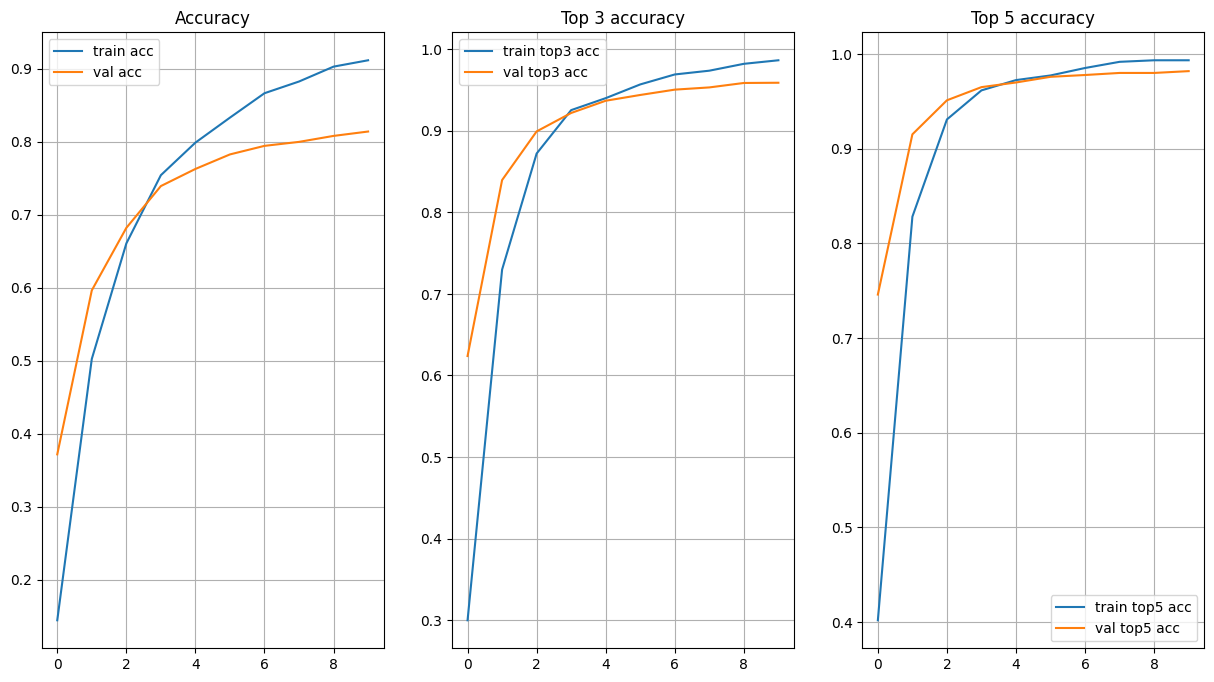

In [ ]:
print_metrics(history, epochs=10)

Теперь обучим ResNet.

In [4]:
augmentation = keras.models.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation([-0.125, 0.125]),
])

aug_train = train_data.map(lambda x, y: (augmentation(x), y))

resnet = keras.applications.ResNet50(include_top=False, input_shape=(img_height, img_width, 3))
for x in resnet.layers:
    x.trainable = False

batch_size = 128

train_data = train_data.map(lambda x, y: (keras.applications.resnet.preprocess_input(x), y)).batch(batch_size)
aug_train = aug_train.map(lambda x, y: (keras.applications.resnet.preprocess_input(x), y)).batch(batch_size)
test_data = test_data.map(lambda x, y: (keras.applications.resnet.preprocess_input(x), y)).batch(batch_size)

model = keras.models.Sequential([
    resnet,
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='tanh'),
    keras.layers.Dense(1024, activation='tanh'),
    keras.layers.Dense(37)
])

top3_acc = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top_3_accuracy')
top5_acc = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_5_accuracy')

model.compile(optimizer=tf.keras.optimizers.Adam(0.00001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy', top3_acc, top5_acc])

tf.config.list_physical_devices('GPU')

history_resnet = model.fit(
    aug_train,
    validation_data=test_data,
    epochs=10
)

94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/10
29/29 [==============================] - 104s 3s/step - loss: 2.6499 - accuracy: 0.3391 - top_3_accuracy: 0.5372 - top_5_accuracy: 0.6236 - val_loss: 1.5444 - val_accuracy: 0.6577 - val_top_3_accuracy: 0.8629 - val_top_5_accuracy: 0.9248
Epoch 2/10
29/29 [==============================] - 51s 2s/step - loss: 1.1183 - accuracy: 0.7668 - top_3_accuracy: 0.9247 - top_5_accuracy: 0.9655 - val_loss: 0.9192 - val_accuracy: 0.7795 - val_top_3_accuracy: 0.9373 - val_top_5_accuracy: 0.9725
Epoch 3/10
29/29 [==============================] - 72s 3s/step - loss: 0.6627 - accuracy: 0.8677 - top_3_accuracy: 0.9747 - top_5_accuracy: 0.9875 - val_loss: 0.7092 - val_accuracy: 0.8215 - val_top_3_accuracy: 0.9608 - val_top_5_accuracy: 0.9820
Epoch 4/10
29/29 [==============================] - 59s 2s/step - loss: 0.4986 - accuracy: 0.9000 - top_3_accuracy: 0.9818 - top_5_accuracy: 0.9913 - val_loss: 0.6215 - val_accuracy: 0.8302 

Результат: loss: 0.1613 - accuracy: 0.9796 - top_3_accuracy: 0.9984 - top_5_accuracy: 0.9995 - val_loss: 0.4425 - val_accuracy: 0.8678 - val_top_3_accuracy: 0.9749 - val_top_5_accuracy: 0.9905

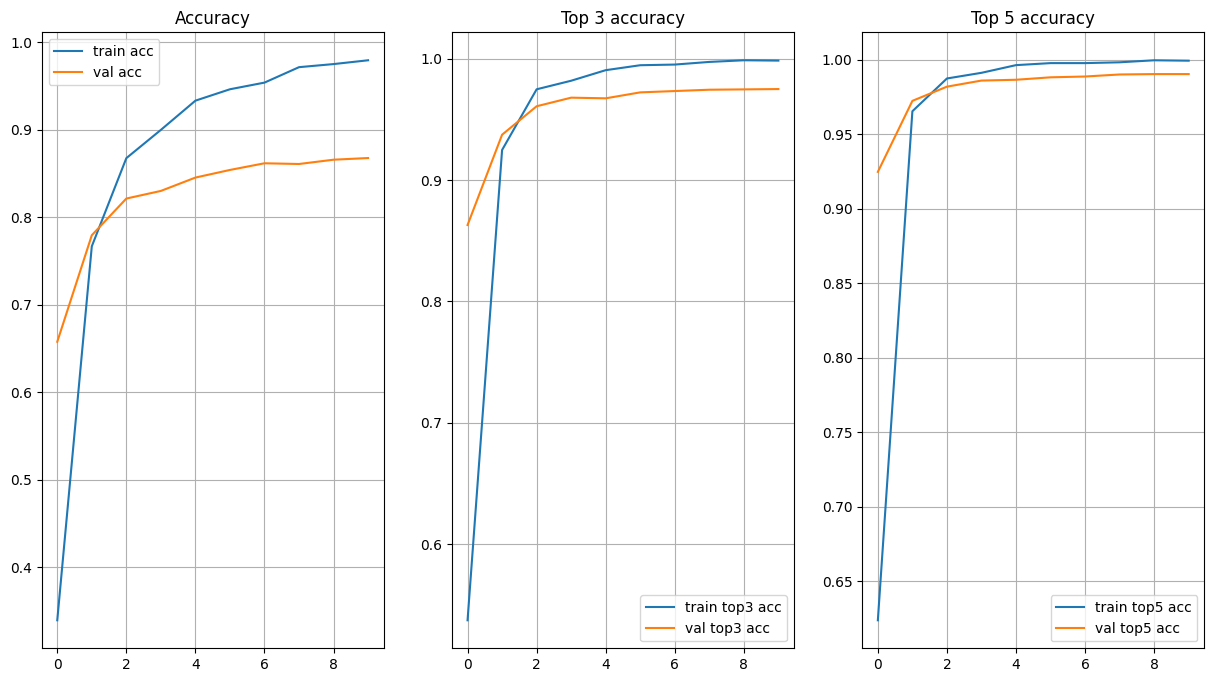

In [5]:
print_metrics(history_resnet, epochs=10)

In [6]:
cats_vs_dogs(model, test_data)

3/3 [==============================] - 2s 480ms/step
0.9910057236304171


Точность двоичной классификации "кошки против собак" - 0.9910057236304171

3/3 [==============================] - 0s 84ms/step


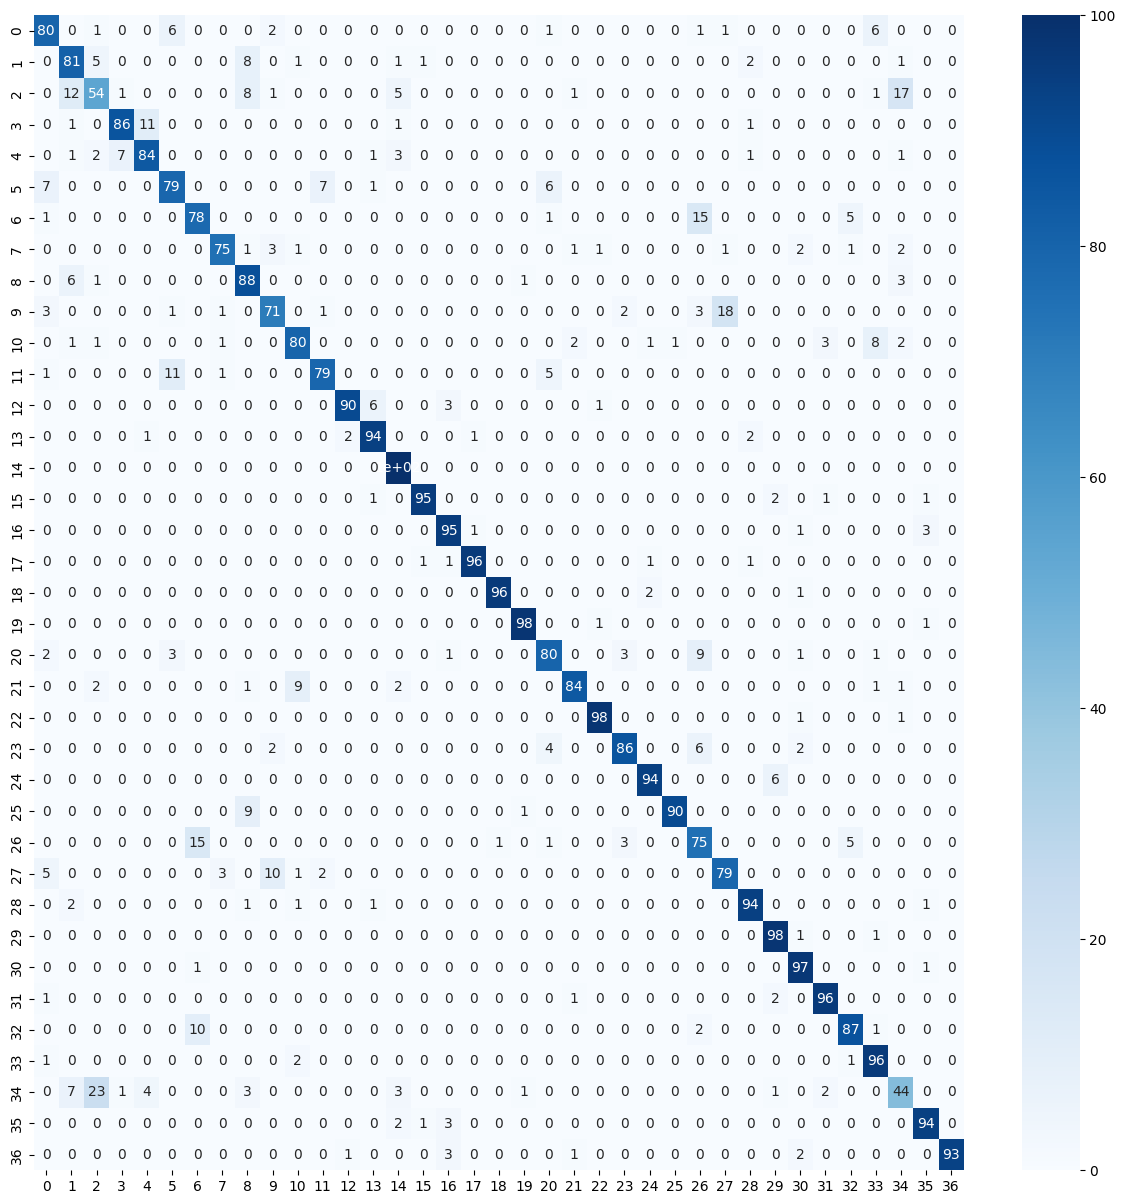

In [7]:
plot_confusion_matrix(model, test_data)

Самой лучшей сетью по точности оказалась ResNet.